## PRACTICA FINAL DEEP LEARNING. Eva Esquivias

In [95]:
#importamos librerías necesarias para el trabajo: 
import numpy as np
from numpy import moveaxis
#import PIL.image
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline 
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import imageio as io
import cv2

from sklearn.preprocessing import MinMaxScaler
import keras
import os
from keras import models
from keras.models import Model
from keras import layers
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, concatenate
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [2]:
###Carga del dataset y primera visión de características
# Como ya lo tengo descargado en local, lo cargo con pandas
data = pd.read_csv('airbnb-listings-extract.csv', sep = ';')
#data.head(3)


In [3]:
# veo el tamaño (número de filas-registros y columnas-variables) del dataset
print(data.shape)


(14780, 89)


Empiezo el proceso de manera sencilla y mi intención es ir de menos a más, complicándome poco a poco según vea mis posibilidades. 
Por ello decido que en una primera versión voy a simplificar la selección de variables y no voy a utilizar las columnas descriptivas. 
Sólo en versiones posteriores, en caso de llegar con tiempo, aprovecharé para usar modelos secuenciales.

Empiezo por la opción propuesta en clase de analizar por un lado datos numéricos y categóricos y por otro imágenes y luego combinarlos para ver las mejores opciones de predicción.

Puesto que partimos del análisis previo del dataset en el módulo de ML, lo primero que haré será un limpiado básico que me facilitará el trabajo posterior. Si no conociera el dataset y no hubiera hecho ya un análisis previo, no podría hacerlo esta limpieza sin análisis. 


In [4]:
#lo primero que tengo que limpiar es la ciudad, ya que el filtro de Madrid del extract no está bien aplicado y me ayudará a mejorar la precisión de mi modelo haciendo el análisis únicamente de Madrid. 
#esto me afecta a los registros con lo que tengo que hacerlo antes de la comprobación y extracción de imágenes de los registros con imágenes. 
data= data[data['City']=='Madrid']

data.shape

(13207, 89)

In [5]:
#Con estos datos, ya puedo revisar las imágenes para eliminar los registros que no tengan imágenes. 

print(data[['Thumbnail Url','Picture Url']].isna().sum())

#la diferencia entre el número de NA en Thumbnail y Picture me anima a intentar quedarme con Picture. 
#Pero después de los problemas que me encuentro con la carga, decido seguir con thumbnail que ocupa menos. si veo que posteriormente tengo tiempo, vuelvo


Thumbnail Url    2478
Picture Url      19  
dtype: int64


In [6]:
# Extraigo las imágenes a un array. Primero creo una lista con la URL y el índice (para identificarlas cuando las trate por separado y vuelva a unirlas con el resto del dataset)
images_paths = []
for i, img_url in enumerate(data['Thumbnail Url']):
  images_paths.append([i, img_url])

# Reviso que está correcto
print(images_paths[:10])
print(len(images_paths))

[[0, 'https://a0.muscache.com/im/pictures/86864154/1356abbf_original.jpg?aki_policy=small'], [1, 'https://a0.muscache.com/im/pictures/69897767/28e73423_original.jpg?aki_policy=small'], [2, 'https://a0.muscache.com/im/pictures/dbcf7393-bb26-40af-ab91-aaf50ef7b380.jpg?aki_policy=small'], [3, 'https://a0.muscache.com/im/pictures/59706828/afecc7d6_original.jpg?aki_policy=small'], [4, 'https://a0.muscache.com/im/pictures/20e6f47e-2a1d-47ea-a814-d02e38efe8ca.jpg?aki_policy=small'], [5, 'https://a0.muscache.com/im/pictures/e684a7f5-038f-48a9-9829-a347a9e76dd9.jpg?aki_policy=small'], [6, 'https://a0.muscache.com/im/pictures/39774047/4b1fac5d_original.jpg?aki_policy=small'], [7, 'https://a0.muscache.com/im/pictures/49838903/35a630eb_original.jpg?aki_policy=small'], [8, 'https://a0.muscache.com/im/pictures/e1eb98be-2800-4982-83f3-c566829ec973.jpg?aki_policy=small'], [9, 'https://a0.muscache.com/im/pictures/13f63727-0893-416d-8efe-7d7ca4790739.jpg?aki_policy=small']]
13207


In [ ]:
# Aprovecho la función propuesta en clase para, reduciendo el tamaño de la imagen,convertir a RGB las imágenes que puedan estar en blanco y negro. Además la función generaliza el posible error que detecte a salida 'None' 
#ESTA CASILLA (Y LAS SIGUIENTES HASTA LA CARGA DE LAS IMÁGENES) NO LA HE EJECUTADO EN LAS ÚLTIMAS PRUEBAS YA QUE CARGO LAS IMÁGENES DE LOCAL QUE EMPLEA MENOS TIEMPO. 
def get_image(data_url, target_size=(128, 128)):
    idx, url = data_url
    try:
        img = io.imread(url)
        if (img.shape[0]< img.shape[1]) and (img.shape[0]<img.shape[2]):
          img= moveaxis(img,0,2)
        img=img[:,:,:3]
        if img.ndim < 3:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img, dsize=target_size)
        return img, idx
    except IOError as err:
        return (None, idx)


In [ ]:
# Creo los tensores para guardar las imágenes y para distinguir las que se guardan de las que no. 

loaded_images = np.zeros((len(images_paths), 128, 128, 3), dtype=np.uint8)

was_loaded = np.zeros(len(images_paths))

#compruebo que están bien creados:

print(loaded_images.shape)
was_loaded

In [ ]:
# con la función get_image descargo las imágenes para cargarlas en los tensores
#import concurrent
from tqdm import tqdm
#with concurrent.futures.ProcessPoolExecutor() as executor:
for (img, idx) in tqdm(map(get_image, images_paths), total=len(images_paths)):
      
    if img is not None:
        loaded_images[idx] = img
        was_loaded[idx] = 1
    else:
        was_loaded[idx] = 0

print('Finished!')
print(f'Number of images loaded: {sum(was_loaded)}/{len(images_paths)}')

In [ ]:
# con la función get_image descargo las imágenes para cargarlas en los tensores
#import concurrent
#from tqdm import tqdm
#with concurrent.futures.ProcessPoolExecutor() as executor:
#  for (img, idx) in tqdm(executor.map(get_image, images_paths), total=len(images_paths)):
    
#    if img is not None:
 #       loaded_images[idx] = img
 #       was_loaded[idx] = 1
  #  else:
   #     was_loaded[idx] = 0
#
#print('Finished!')
#print(f'Number of images loaded: {sum(was_loaded)}/{len(images_paths)}')

In [ ]:
# Guardo los tensores para no tener que volver a realizar el proceso, ya que es largo. 
np.save('images.npy', loaded_images)
np.save('was_loaded.npy', was_loaded)

#compruebo lo que he guardado
was_loaded

#y el tamaño del tensor de las imágenes. 
loaded_images.shape
#incluye todas, las que han dado error y las que no. 


In [7]:
#en las últimas versiones cargo las imágenes descargadas con las indicaciones de los apartados anteriores con este comando y a partir de este punto continuo. 
loaded_images = np.load('images.npy')
was_loaded = np.load('was_loaded.npy')


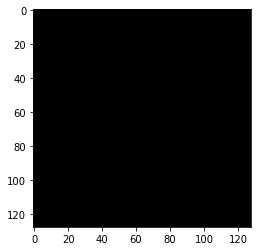

In [8]:
#creo un conjunto con las imágenes que han dado error 
loaded_imgs_error =loaded_images[was_loaded == 0]
loaded_imgs_error.shape

#confirmo que las imágenes que quito son error (imagen completamente en negro en todas las pruebas)
index = 15
plt.imshow(loaded_imgs_error[index])

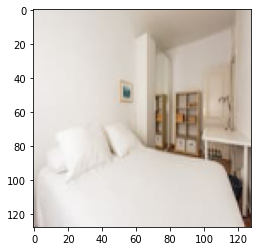

In [9]:
#dejo sólo las que se han cargado del tensor de imágenes igual que quitaremos los errores del dataset. 
loaded_imgs_clean = loaded_images[was_loaded == 1]
loaded_imgs_clean.shape


#pruebo una imagen al azar..voy modificando el índice como hicimos en clase. 
index = 15
plt.imshow(loaded_imgs_clean[index])

In [10]:
# Me quedo únicamente en el dataset con los registros que contienen imágenes. 
data_with_imgs = data[was_loaded == 1]

print(data_with_imgs.shape)
data_with_imgs.head()

(10700, 89)


,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Thumbnail Url,Medium Url,Picture Url,XL Picture Url,Host ID,Host URL,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Thumbnail Url,Host Picture Url,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Calendar last Scraped,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
40,6478626,https://www.airbnb.com/rooms/6478626,20170407214119,2017-04-08,Habitación con baño .,"Habitación con cama de 150 , para una o dos personas , tiene un baño propio , tranquilo , la zona esta muy bien , cerca del centro , con autobuses , taxi y metro de conde de Casal abajo de casa ., cerca del parque del retiro .","Tranquilidad y respeto del espacio room with bathroom equipped with a 150 Cm bed for one or two person. per night. Located in a very good and quite area close to downtown. Bus, taxy or metro (Conde de Casal Station) well connected. The metro station is just in front of the main entrance.","Habitación con cama de 150 , para una o dos personas , tiene un baño propio , tranquilo , la zona esta muy bien , cerca del centro , con autobuses , taxi y metro de conde de Casal abajo de casa ., cerca del parque del retiro . Tranquilidad y respeto del espacio room with bathroom equipped with a 150 Cm bed for one or two person. per night. Located in a very good and quite area close to downtown. Bus, taxy or metro (Conde de Casal Station) well connected. The metro station is just in front of the main entrance. Pueden usar la nevera , microondas , wifi . Cualquier cosa Q necesiten estaremos para ayudarles Barrio muy bien comunicado , metro , autobús , taxi , abajo de casa , súper mercados , tiendas , bares , restaurantes , farmacia todo muy cerca . Metro conde de Casal abajo de casa . Líneas de autobuses hacia el centro . Base de taxi .",none,"Barrio muy bien comunicado , metro , autobús , taxi , abajo de casa , súper mercados , tiendas , bares , restaurantes , farmacia todo muy cerca .",NaN,Metro conde de Casal abajo de casa . Líneas de autobuses hacia el centro . Base de taxi .,"Pueden usar la nevera , microondas , wifi .",Cualquier cosa Q necesiten estaremos para ayudarles,"Si son fumadores podéis fumar en un patio Q hay en la cocina , en el resto del apartamento no .",https://a0.muscache.com/im/pictures/86864154/1356abbf_original.jpg?aki_policy=small,https://a0.muscache.com/im/pictures/86864154/1356abbf_original.jpg?aki_policy=medium,https://public.opendatasoft.com/api/v2/catalog/datasets/airbnb-listings/files/04b47ccd1610a1c42e0e79e55c0d5897,https://a0.muscache.com/im/pictures/86864154/1356abbf_original.jpg?aki_policy=x_large,25709853,https://www.airbnb.com/users/show/25709853,Vílma,2015-01-06,"Madrid, Community of Madrid, Spain",NaN,within an hour,84.0,NaN,https://a0.muscache.com/im/users/25709853/profile_pic/1433326196/original.jpg?aki_policy=profile_small,https://a0.muscache.com/im/users/25709853/profile_pic/1433326196/original.jpg?aki_policy=profile_x_medium,NaN,3.0,3.0,"email,phone,reviews","Madrid, Comunidad de Madrid 28007, Spain",NaN,Niño Jesús,Retiro,Madrid,Comunidad de 

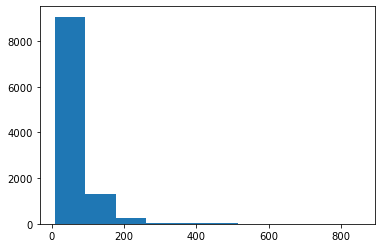

In [109]:
#Una vez eliminados los registros sin imágenes, 
#creo el conjunto etiqueta. Valor único para regresión: 
y_reg = data_with_imgs['Price']

# Plotting the labels
import matplotlib.pyplot as plt
plt.hist(y_reg, bins=10)
plt.show()


Tengo por un lado un dataset para limpiar y preseleccionar variables numéricas y categóricas y por otro las imágenes en un tensor para a partir de ellas hacer el análisis y la predicción del precio. Empiezo por los datos numéricos y categóricos tal y como se aconseja en el enunciado de la práctica.

## PREPROCESAMIENTO y REGRESIÓN DATOS NÚMERICOS Y CATEGÓRICOS
De la práctica de ML recupero el procesamiento de los datos numéricos y categóricos.

In [12]:
#Tras el estudio realizado en ML, empiezo por eliminar las siguientes variables de todo el dataset antes de hacer el split train test (esto no lo haría de no haber hecho análisis previo en el módulo anterior, pero sé que son variables con las que no voy a contar):

#las variables descriptivas (ya que en principio no voy a realizar análisis secuencial)
#las que contienen URL del dataset, ya tengo las imágenes descargadas en el tensor. 
#datos de country, country code, estado, ... ya que he reducido la ciudad a Madrid y todas son iguales. 
#la fecha de extracción y el ID de extracción son iguales en todos los registros. 
#'Host Acceptance Rate','Jurisdiction Names','Has Availability' porque son todos nulos
#license y square feet tienen muy pocos valores no nulos. Se podría valorar hacer una estimación en versiones posteriores. 
#'Neighbourhood' y neighbourhood grouped, me quedo con neighbourhood cleansed. 
#datos del host, ya que no son en principio relevantes para el precio a excepción del host since, que lo dejo para convertirlo en antiguedad en airbnb. 
#datos de precio 'Weekly Price','Monthly Price'. ya tengo Price 
#'First Review' ya tengo antiguedad
#'Last Review''Reviews per Month' 
#dejo latitud y longitud y elimino 'Geolocation']

data_with_imgs= data_with_imgs.drop(['Name','Summary','Space','Description','Neighborhood Overview','Neighbourhood Group Cleansed','Notes', 'Transit','Access','Interaction','House Rules','Host Thumbnail Url','Host Picture Url','Host URL','Listing Url','Medium Url','Picture Url','Thumbnail Url','XL Picture Url','Scrape ID','Country Code','Country','Host Acceptance Rate','Jurisdiction Names','Has Availability','Neighbourhood','Last Scraped','Host Name','Host Location','Host About','Host Neighbourhood','Host Verifications','Weekly Price','Monthly Price','Host Listings Count', 'Host ID','Market', 'Smart Location','Zipcode','Experiences Offered','State','Street','Calendar last Scraped','First Review','Last Review', 'Calendar Updated','Calculated host listings count','Host Total Listings Count', 'Reviews per Month' , 'License','Square Feet', 'Geolocation','City','Availability 30','Availability 60','Availability 90','Maximum Nights'], axis= 1)
data_with_imgs.shape


(10700, 32)

In [13]:
data_with_imgs.info()
#de las variables que me quedan, realizo las modificaciones que me funcionaron en ML

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10700 entries, 40 to 14757
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           10700 non-null  int64  
 1   Host Since                   10697 non-null  object 
 2   Host Response Time           9414 non-null   object 
 3   Host Response Rate           9414 non-null   float64
 4   Neighbourhood Cleansed       10700 non-null  object 
 5   Latitude                     10700 non-null  float64
 6   Longitude                    10700 non-null  float64
 7   Property Type                10700 non-null  object 
 8   Room Type                    10700 non-null  object 
 9   Accommodates                 10700 non-null  int64  
 10  Bathrooms                    10665 non-null  float64
 11  Bedrooms                     10679 non-null  float64
 12  Beds                         10661 non-null  float64
 13  Bed Type       

In [14]:
#host since lo convierto a antiguedad en airbnb
data_with_imgs['Host Since'] = pd.to_datetime(data_with_imgs['Host Since'])
data_with_imgs['Antiguedad']= 2017 - data_with_imgs['Host Since'].dt.year
data_with_imgs['Antiguedad'].fillna(data_with_imgs['Antiguedad'].mean(),inplace= True)
data_with_imgs= data_with_imgs.drop(['Host Since'],axis=1)

#convierto variables categóricas a numéricas
mean_encodeRespTime= data_with_imgs.groupby('Host Response Time')['Price'].mean()
data_with_imgs.loc[:,'Host_Resp_Time_enc']=data_with_imgs['Host Response Time'].map(mean_encodeRespTime)
mean_encodeNeigh= data_with_imgs.groupby('Neighbourhood Cleansed')['Price'].mean()
data_with_imgs.loc[:,'Neighbourhood_enc']=data_with_imgs['Neighbourhood Cleansed'].map(mean_encodeNeigh)
mean_encodePropType= data_with_imgs.groupby('Property Type')['Price'].mean()
data_with_imgs.loc[:,'PropertyType_enc']=data_with_imgs['Property Type'].map(mean_encodePropType)
mean_encodeRoomType= data_with_imgs.groupby('Room Type')['Price'].mean()
data_with_imgs.loc[:,'RoomType_enc']=data_with_imgs['Room Type'].map(mean_encodeRoomType)
mean_encodeBedType= data_with_imgs.groupby('Bed Type')['Price'].mean()
data_with_imgs.loc[:,'BedType_enc']=data_with_imgs['Bed Type'].map(mean_encodeBedType)
mean_encodeCancPol= data_with_imgs.groupby('Cancellation Policy')['Price'].mean()
data_with_imgs.loc[:,'CancellationPolicy_enc']=data_with_imgs['Cancellation Policy'].map(mean_encodeCancPol)
data_with_imgs= data_with_imgs.drop(['Host Response Time','Neighbourhood Cleansed','Property Type','Room Type','Bed Type','Cancellation Policy'],axis=1)

#convierto Amenities y Features en número sumando el total de sus elementos. 
data_with_imgs['Total_Amenities'] = data_with_imgs['Amenities'].apply(lambda x: len(str(x).split(',')))
data_with_imgs['Total_Features'] = data_with_imgs['Features'].apply(lambda x: len(str(x).split(',')))
data_with_imgs= data_with_imgs.drop(['Amenities', 'Features'],axis=1)

#saco la media de las reviews
data_with_imgs['average_review'] = data_with_imgs[['Review Scores Rating','Review Scores Accuracy','Review Scores Cleanliness','Review Scores Checkin','Review Scores Communication','Review Scores Location','Review Scores Value']].mean(axis=1)
data_with_imgs= data_with_imgs.drop(['Review Scores Rating','Review Scores Accuracy','Review Scores Cleanliness','Review Scores Checkin','Review Scores Communication','Review Scores Location','Review Scores Value'],axis=1)

#relleno los na con los elementos más adecuados según de qué variable se trate.
#bien sustituyo por 0 cuando entiendo que la ausencia es que no existe coste 
data_with_imgs['Security Deposit'].fillna(0,inplace=True)
data_with_imgs['Cleaning Fee'].fillna(0,inplace=True)
#las siguientes variables las relleno con la moda para obtener valores enteros. 
data_with_imgs['Beds'].fillna(data_with_imgs['Beds'].mode()[0], inplace= True)
data_with_imgs['Bathrooms'].fillna(data_with_imgs['Bathrooms'].mode()[0], inplace= True)
data_with_imgs['Bedrooms'].fillna(data_with_imgs['Bedrooms'].mode()[0], inplace= True)
#y el resto de na lo sustituyo por la media.
data_with_imgs.fillna(data_with_imgs.mean(), inplace= True)

#cambio la columna del precio a la primera posición
col = data_with_imgs.pop("Price")
data_with_imgs.insert(0, col.name, col)

#creo nueva variable recomendada para este tipo de estudios a partir de combinación de variables existentes. 
#data_with_imgs['bedrooms_squared'] = data_with_imgs['Bedrooms'].apply(lambda x: x**2)
#data_with_imgs['bed_bath_rooms']   = data_with_imgs['Bedrooms']*data_with_imgs['Bathrooms']
data_with_imgs['lat_plus_long']    = data_with_imgs['Latitude']*data_with_imgs['Longitude']


In [15]:
data_with_imgs.isnull().sum() #para contar na

Price                     0
ID                        0
Host Response Rate        0
Latitude                  0
Longitude                 0
Accommodates              0
Bathrooms                 0
Bedrooms                  0
Beds                      0
Security Deposit          0
Cleaning Fee              0
Guests Included           0
Extra People              0
Minimum Nights            0
Availability 365          0
Number of Reviews         0
Antiguedad                0
Host_Resp_Time_enc        0
Neighbourhood_enc         0
PropertyType_enc          0
RoomType_enc              0
BedType_enc               0
CancellationPolicy_enc    0
Total_Amenities           0
Total_Features            0
average_review            0
lat_plus_long             0
dtype: int64

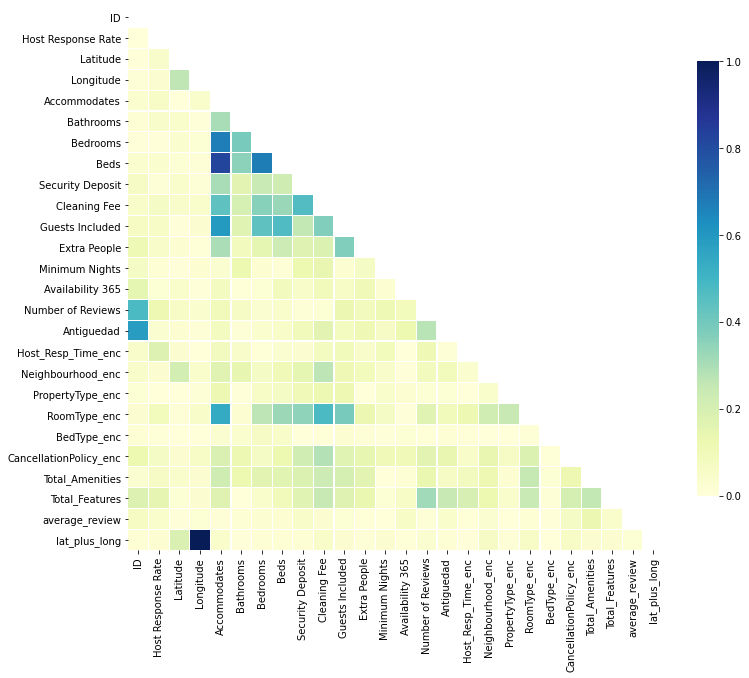

In [16]:
#hago matriz de correlación por confirmar y veo que tengo variables muy correlacionadas entre sí. compruebo con los valores de la correlación con precio cuál de las parejas me interesa quedarme. 
corr = np.abs(data_with_imgs.drop(['Price'], axis=1).corr())

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [17]:
data_with_imgs.corr()['Price'].sort_values(ascending=False)
#Entre Beds y accommodates me quedo con Accommodates
#elimino también longitude


Price                     1.000000
Accommodates              0.592458
Bedrooms                  0.535962
Cleaning Fee              0.513561
Beds                      0.490859
RoomType_enc              0.479618
Guests Included           0.387943
Neighbourhood_enc         0.348811
Security Deposit          0.327174
Bathrooms                 0.320155
Total_Amenities           0.211382
Total_Features            0.125252
PropertyType_enc          0.122336
CancellationPolicy_enc    0.120506
Extra People              0.109109
average_review            0.085191
Host_Resp_Time_enc        0.083459
Availability 365          0.078952
Latitude                  0.074999
Antiguedad                0.073236
Minimum Nights            0.039313
BedType_enc               0.039213
ID                       -0.007261
Host Response Rate       -0.010334
Number of Reviews        -0.013074
Longitude                -0.015609
lat_plus_long            -0.021824
Name: Price, dtype: float64

In [18]:
data_with_imgs=data_with_imgs.drop(['Beds','Longitude'], axis=1)

#confirmo el tamaño de mis datos numéricos y categóricos
data_with_imgs.shape

(10700, 25)

In [110]:
#separo el precio del resto de variables. precio ya lo tengo en y_reg, creo df con variables x.
x_reg= data_with_imgs.drop(['Price'], axis=1)


In [113]:
print(x_reg.shape)
print(y_reg.shape)

(10700, 24)
(10700,)


In [19]:
#confirmo que tengo el mismo número de entradas en el tensor de imágenes. 
loaded_imgs_clean.shape

(10700, 128, 128, 3)

In [125]:
#A partir de lo avanzado en ML, una vez reducido a 25 características. ya realizo la división entre train y test y empiezo a entrenar y valorar capacidad de predicción o ajustes adicionales. 

from sklearn.model_selection import train_test_split

x_train_orig, x_test_orig, y_train_orig, y_test_orig = train_test_split(x_reg,y_reg, test_size=0.1, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de x_train_orig: {x_train_orig.shape}')
print(f'Dimensiones del dataset de x_test_orig: {x_test_orig.shape}')
print(f'Dimensiones del dataset de y_train_orig: {y_train_orig.shape}')
print(f'Dimensiones del dataset de y_test_orig: {y_test_orig.shape}')

# Guardamos por si luego lo necesitamos. 
x_train_orig.to_csv('train.csv', sep=';', decimal='.', index=False)
x_test_orig.to_csv('test.csv', sep=';', decimal='.', index=False)
y_train_orig.to_csv('train.csv', sep=';', decimal='.', index=False)
y_test_orig.to_csv('test.csv', sep=';', decimal='.', index=False)

# El data set de test lo reservo para las comprobaciones finales del modelo completo (espero que me de tiempo). 
# En el de train llevo a cabo entrenamiento y análisis.

Dimensiones del dataset de x_train_orig: (9630, 24)
Dimensiones del dataset de x_test_orig: (1070, 24)
Dimensiones del dataset de y_train_orig: (9630,)
Dimensiones del dataset de y_test_orig: (1070,)


In [126]:
y_train_orig=np.expand_dims(y_train_orig,axis=1)
y_test_orig=np.expand_dims(y_test_orig,axis=1)

In [134]:
# Escalamos el DataFrame. intento con el standardscaler pero no consigo que los datos me convenzan (algo estoy haciendo mal).
#pruebo directamente normalización. normalizo también etiquetas. apunto revisar outliers para segunda ronda.  

scaler = MinMaxScaler()
# transform data
xscalednorm = scaler.fit_transform(x_train_orig)

target_scaler = MinMaxScaler()
yscalednorm= target_scaler.fit_transform(y_train_orig)

#train es el 90% del data set. Vuelvo a dividirlo para tener los datos de validación a la hora de realizar el modelo.
x_train, x_valid, y_train, y_valid = train_test_split(xscalednorm, yscalednorm, test_size=0.1)

print(x_train.max())
print(x_train.min())
print(x_valid.max())
print(x_valid.min())
print(y_train.max())
print(y_train.min())
print(y_valid.max())
print(y_valid.min())








1.0000000000000002
0.0
1.0000000000000002
0.0
0.9999999999999999
0.0
0.8216409036860879
0.0011890606420927475


In [180]:
print(f'Dimensiones del dataset de x_train: {x_train.shape}')
print(f'Dimensiones del dataset de x_valid: {x_valid.shape}')
print(f'Dimensiones del dataset de y_train: {y_train.shape}')
print(f'Dimensiones del dataset de y_valid: {y_valid.shape}')

Dimensiones del dataset de x_train: (8667, 24)
Dimensiones del dataset de x_valid: (963, 24)
Dimensiones del dataset de y_train: (8667, 1)
Dimensiones del dataset de y_valid: (963, 1)


In [135]:
# Empiezo a probar un modelo sencillo de MLP, también llamado FC
from keras.models import Sequential
from keras.layers import Dense

#tal y como se recomienda en clase, empiezo con 3 capas. 
#Pruebo con 32 neuronas, 16 y 1 (porque quiero un único valor de precio) Pruebo con función de activación relu que en principio parece que suele dar buenos resultados en capas intermedias y luego probaré con tanh quizá en la segunda capa.  
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32,input_shape=(x_train.shape[1],), activation='relu'),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dense(1, activation= 'linear'),
])

In [136]:
model.summary()
#confirmo que los 800 parámetros de la primera capa son los 24 elementos de entrada *32 + 32 bias(hay tantos como neuronas)
#en la segunda capa los parámetros salen de multiplicar la entrada que son 32*16 +16 bias=528
#la tercera capa son 16 elementos de entrada por 1 salida + 1=17


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 32)                800       
_________________________________________________________________
dense_43 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 17        
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________


In [137]:
#pruebo con optimizador adam porque se comentó que era el más utilizado y daba buenos resultados al ser una buena combinación entre RMSProp y gradient descent with momentum 
#como voy a hacer una regresión, pongo como función de pérdida el error cuadrático medio. 
model.compile(optimizer='adam',
              loss='mean_squared_error')

model.fit(x_train, y_train,
          validation_data=(x_valid, y_valid),
          epochs=20,
          batch_size=4)

Epoch 1/20
2167/2167 [==============================] - 2s 1ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 2/20
2167/2167 [==============================] - 1s 591us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 3/20
2167/2167 [==============================] - 1s 595us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 4/20
2167/2167 [==============================] - 1s 586us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 5/20
2167/2167 [==============================] - 1s 586us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 6/20
2167/2167 [==============================] - 1s 671us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 7/20
2167/2167 [==============================] - 1s 665us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 8/20
2167/2167 [==============================] - 1s 614us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 9/20
2167/2167 [==============================] - 1s 608us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 10/20
2167/2167 [==============================] - 1s 607us/

In [138]:
#pruebo a desnormalizar para tener una idea real. 
y_pred = model.predict(x_train)
y_pred = target_scaler.inverse_transform(y_pred)
y_traininv = target_scaler.inverse_transform(y_train)


print(y_pred.max())
print(y_pred.min())

error= np.abs(y_pred-y_traininv)
print(error)

media_error=error.mean()

print(media_error)
#El error medio en euros son 16.69€, mejorable aunque si pienso en los outliers no es muy significativo

863.59045
-34.583694
[[ 5.24235535]
 [ 7.1634407 ]
 [18.2710762 ]
 ...
 [11.34543228]
 [ 2.20608139]
 [ 3.01673126]]
16.694937737312397


In [139]:
#No parece un valor malo pero por si acaso realizo varias pruebas más:
#Pruebo modificando, ampliando las neuronas y cambiando la función de activación de la segunda capa, recomiendan tanh llegando al final, aunque este es breve. 
from keras.models import Sequential
from keras.layers import Dense

model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64,input_shape=(x_train.shape[1],), activation='relu'),
    tf.keras.layers.Dense(32,activation='tanh'),
    tf.keras.layers.Dense(1, activation= 'linear'),
])

model2.compile(optimizer='adam',
              loss='mean_squared_error')

#y amplío el número de epocas y pruebo a reducir el batch size
model2.fit(x_train, y_train,
          validation_data=(x_valid, y_valid),
          epochs=40,
          batch_size=2)

Epoch 1/40
4334/4334 [==============================] - 3s 687us/step - loss: 0.0025 - val_loss: 0.0018
Epoch 2/40
4334/4334 [==============================] - 3s 621us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 3/40
4334/4334 [==============================] - 3s 678us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 4/40
4334/4334 [==============================] - 3s 691us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 5/40
4334/4334 [==============================] - 3s 671us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 6/40
4334/4334 [==============================] - 3s 642us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 7/40
4334/4334 [==============================] - 3s 663us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 8/40
4334/4334 [==============================] - 3s 671us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 9/40
4334/4334 [==============================] - 3s 671us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 10/40
4334/4334 [==============================] - 3s 668u

In [140]:
#pruebo a meter regularización l2 valor default 
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64,input_shape=(x_train.shape[1],), activation='relu',kernel_regularizer='l2'),
    tf.keras.layers.Dense(32,activation='tanh'),
    tf.keras.layers.Dense(1, activation= 'linear'),
])
model3.compile(optimizer='adam',
              loss='mean_squared_error')
model3.fit(x_train, y_train,
          validation_data=(x_valid, y_valid),
          epochs=20,
          batch_size=2)


Epoch 1/20
4334/4334 [==============================] - 3s 702us/step - loss: 0.0126 - val_loss: 0.0026
Epoch 2/20
4334/4334 [==============================] - 3s 645us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 3/20
4334/4334 [==============================] - 3s 685us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 4/20
4334/4334 [==============================] - 3s 680us/step - loss: 0.0024 - val_loss: 0.0027
Epoch 5/20
4334/4334 [==============================] - 3s 672us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 6/20
4334/4334 [==============================] - 3s 667us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 7/20
4334/4334 [==============================] - 3s 685us/step - loss: 0.0023 - val_loss: 0.0032
Epoch 8/20
4334/4334 [==============================] - 3s 687us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 9/20
4334/4334 [==============================] - 3s 684us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 10/20
4334/4334 [==============================] - 3s 680u

In [ ]:
#pensaba probar con l1 para ver la diferencia (en alguna prueba anterior mejoró) pero no parece haber mucho overfitting y los datos no han mejorado con la regularización.
#model4 = tf.keras.models.Sequential([
#    tf.keras.layers.Dense(64,input_shape=(x_train.shape[1],), activation='relu',kernel_regularizer='l1'),
#    tf.keras.layers.Dense(32,activation='tanh'),
 #   tf.keras.layers.Dense(1, activation= 'linear'),
#])

#model4.compile(optimizer='adam',
 #             loss='mean_squared_error')

#model4.fit(x_train, y_train,
 #         validation_data=(x_valid, y_valid),
 #         epochs=20,
 #         batch_size=2)

In [141]:
#pruebo con RMSProp en vez de adam con la L2 
model5 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64,input_shape=(x_train.shape[1],), activation='relu',kernel_regularizer='l1'),
    tf.keras.layers.Dense(32,activation='tanh'),
    tf.keras.layers.Dense(1, activation= 'linear'),
])

model5.compile(optimizer='RMSProp',
              loss='mean_squared_error')

model5.fit(x_train, y_train,
          validation_data=(x_valid, y_valid),
          epochs=20,
          batch_size=2)

#empieza en un valor más alto que el resto y con las epoch que le doy no le da tiempo a bajar...eso sí, no hay prácticamente diferencia entre train y valid

Epoch 1/20
4334/4334 [==============================] - 3s 609us/step - loss: 0.0592 - val_loss: 0.0110
Epoch 2/20
4334/4334 [==============================] - 3s 618us/step - loss: 0.0114 - val_loss: 0.0109
Epoch 3/20
4334/4334 [==============================] - 3s 601us/step - loss: 0.0113 - val_loss: 0.0107
Epoch 4/20
4334/4334 [==============================] - 3s 627us/step - loss: 0.0113 - val_loss: 0.0117
Epoch 5/20
4334/4334 [==============================] - 3s 626us/step - loss: 0.0113 - val_loss: 0.0113
Epoch 6/20
4334/4334 [==============================] - 3s 697us/step - loss: 0.0113 - val_loss: 0.0108
Epoch 7/20
4334/4334 [==============================] - 3s 642us/step - loss: 0.0113 - val_loss: 0.0138
Epoch 8/20
4334/4334 [==============================] - 3s 590us/step - loss: 0.0113 - val_loss: 0.0115
Epoch 9/20
4334/4334 [==============================] - 3s 632us/step - loss: 0.0113 - val_loss: 0.0108
Epoch 10/20
4334/4334 [==============================] - 3s 624u

In [ ]:
#en las pruebas previas analizo opción de meter la regularización en las dos capas pero finalmente no lo valoro. 
#model = tf.keras.models.Sequential([
#    tf.keras.layers.Dense(64,input_shape=(x_train.shape[1],), activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.5)),
#    tf.keras.layers.Dense(32,activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(0.5)),
#    tf.keras.layers.Dense(1, activation= 'linear'),
#])

#model.compile(optimizer='adam',
 #             loss='mean_squared_error')

#model.fit(x_train, y_train,
 #         validation_data=(x_valid, y_valid),
  #        epochs=20,
   #       batch_size=2)


 Parece que mis resultados empeoran con el cambio de optimizer. 
 
 Vuelvo a probar el modelo 1 con adam y más épocas para poder ver si es significativamente mejor que el 2.

In [142]:
model.compile(optimizer='adam',
              loss='mean_squared_error')

model.fit(x_train, y_train,
          validation_data=(x_valid, y_valid),
          epochs=40,
          batch_size=4)

Epoch 1/40
2167/2167 [==============================] - 1s 608us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 2/40
2167/2167 [==============================] - 1s 661us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 3/40
2167/2167 [==============================] - 1s 691us/step - loss: 0.0012 - val_loss: 0.0015
Epoch 4/40
2167/2167 [==============================] - 2s 729us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 5/40
2167/2167 [==============================] - 1s 604us/step - loss: 0.0012 - val_loss: 0.0015
Epoch 6/40
2167/2167 [==============================] - 1s 593us/step - loss: 0.0012 - val_loss: 0.0017
Epoch 7/40
2167/2167 [==============================] - 1s 549us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 8/40
2167/2167 [==============================] - 2s 753us/step - loss: 0.0012 - val_loss: 0.001300
Epoch 9/40
2167/2167 [==============================] - 1s 648us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 10/40
2167/2167 [==============================] - 1s 60

In [ ]:
#parece que los datos de train aprenden pero aumenta la diferencia con validation. pruebo el modelo con l1 y 40 epocas. 

In [143]:
model4 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64,input_shape=(x_train.shape[1],), activation='relu',kernel_regularizer='l1'),
    tf.keras.layers.Dense(32,activation='tanh'),
    tf.keras.layers.Dense(1, activation= 'linear'),
])

model4.compile(optimizer='adam',
              loss='mean_squared_error')

model4.fit(x_train, y_train,
          validation_data=(x_valid, y_valid),
          epochs=40,
          batch_size=2)

Epoch 1/40
4334/4334 [==============================] - 3s 644us/step - loss: 0.0572 - val_loss: 0.0053
Epoch 2/40
4334/4334 [==============================] - 3s 622us/step - loss: 0.0056 - val_loss: 0.0063
Epoch 3/40
4334/4334 [==============================] - 3s 609us/step - loss: 0.0056 - val_loss: 0.0054
Epoch 4/40
4334/4334 [==============================] - 3s 650us/step - loss: 0.0056 - val_loss: 0.0050
Epoch 5/40
4334/4334 [==============================] - 3s 617us/step - loss: 0.0056 - val_loss: 0.0052
Epoch 6/40
4334/4334 [==============================] - 3s 643us/step - loss: 0.0056 - val_loss: 0.0051
Epoch 7/40
4334/4334 [==============================] - 3s 661us/step - loss: 0.0055 - val_loss: 0.0049
Epoch 8/40
4334/4334 [==============================] - 3s 675us/step - loss: 0.0056 - val_loss: 0.0050
Epoch 9/40
4334/4334 [==============================] - 3s 661us/step - loss: 0.0056 - val_loss: 0.0051
Epoch 10/40
4334/4334 [==============================] - 3s 686u

In [ ]:
Me quedo con el primer modelo con adam.
Guardo una copia del modelo2 (porque tiene más neuronas y un resultado similar) sin la capa con la función de activación lineal final para cuando combine los datos numericos y categoricos con el de imágenes. 


In [168]:
#modelo para combinar con imágenes. 
#No pongo función de activación tanh en la segunda capa como antes ya que será capa intermedia en el modelo combinado y reservo la capa adicional que añada para usar la función de activación tanh
modeloMLP= tf.keras.models.Sequential([
    tf.keras.layers.Dense(64,input_shape=(x_train.shape[1],), activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    ])

In [145]:
modeloMLP.output

<tf.Tensor 'dense_58/Tanh:0' shape=(None, 32) dtype=float32>

In [ ]:
#También he probado con el random initializer de los pesos, no defino learning rate ya que leo que con adam como optimizer no es necesario definir el learning rate ya que cada parámetro tiene su propio learning rate 
#investigar si sobra tiempo. 
#también probaría con sigmoide como salida (ya que tengo normalizados los datos). en una de los pruebas me dio un resultado mejor, aunque no lo he podido repetir.
#dejo la opción de probar con model.evaluate con los datos de test para poder usarlos primero en el modelo combinado. 
#si veo que puedo volver a esto metería más capas, revisaría la normalización... y revisaria learning rate 

In [179]:
#aunque tardan poco, hago copia de los modelos por si hay que subirlos al colab
model.save('modeloMLP.h5')
model.save('model.h5')
model.save('model2.h5')
model.save('model3.h5')
model.save('model4.h5')
model.save('model5.h5')

#new_model = keras.models.load_model('path_to_my_model.h5')


## REGRESIÓN CON IMAGENES

In [146]:
#Veo el tensor que tengo separado con imágenes bien cargadas antes de normalizar. 
print(loaded_imgs_clean.shape)
print(loaded_imgs_clean.max())
print(loaded_imgs_clean.min())

(10700, 128, 128, 3)
255
0


In [147]:
#normalizo inputs
norm_imgs=loaded_imgs_clean/255.0

In [148]:
print(norm_imgs.max())
norm_imgs.dtype

1.0


dtype('float64')

In [149]:
#divido entre train y test para reservar una porción para las pruebas finales sin tocar y sin que aprenda de los datos.
x_img_train_orig, x_img_test_orig= train_test_split(norm_imgs,test_size=0.1)

In [150]:
x_img_train_orig.shape

(9630, 128, 128, 3)

In [151]:
x_img_test_orig.shape
#el x_img_test_orig se guarda para la prueba final junto con el x_test_orig de los datos numéricos

(1070, 128, 128, 3)

In [157]:
#vuelvo a dividir para tener train y valid para entrenar sin tocar test. 

x_img_train, x_img_valid = train_test_split(x_img_train_orig, test_size=0.1)


In [158]:
print(x_img_train.shape)
print(x_img_valid.shape)
print(y_train.shape)
print(y_valid.shape)


(8667, 128, 128, 3)
(963, 128, 128, 3)
(8667, 1)
(963, 1)


In [161]:
#Pruebo un primer modelo de CNN según algunas de las recomendaciones de clase, con dropout entre las capas convolucionales. Max pooling suele dar mejores resultados que avg y flatten es necesario para las capas FC
#acabo en función de activación lineal y 1 neurona porque quiero que me de un valor (estimar el precio)
img_model = tf.keras.Sequential()
img_model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', kernel_initializer='random_normal', input_shape=(128,128,3)))
img_model.add(tf.keras.layers.Dropout(0.25))
img_model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
img_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
img_model.add(tf.keras.layers.Flatten())
img_model.add(tf.keras.layers.Dense(32, activation='relu'))
img_model.add(tf.keras.layers.Dropout(0.3))
img_model.add(tf.keras.layers.Dense(1, activation='linear'))



In [162]:
img_model.summary() 
#resaltar el cambio en el número de parámetros cuando paso de convolucional a FC. 

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
dropout_13 (Dropout)         (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 246016)            0         
_________________________________________________________________
dense_63 (Dense)             (None, 32)                7872544   
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)              

In [163]:
img_model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam()
               )

In [164]:
img_model.fit(x_img_train,
          y_train,
          batch_size=4,
          epochs=2,
          verbose=1,
          validation_data=(x_img_valid, y_valid))

Epoch 1/2
2167/2167 [==============================] - 339s 157ms/step - loss: 0.4417 - val_loss: 0.0037
Epoch 2/2
2167/2167 [==============================] - 347s 160ms/step - loss: 0.0039 - val_loss: 0.0037


In [165]:
model.save_weights('img_model.h5')
#model.load_weights('img_model.h5')

In [166]:
#Pruebo con un modelo base preentrenado y añado un global average pooling que combina Batch normalization (da robustez al modelo, reduce overfitting), pooling y flatten
input_x=(128,128,3)

base_model = VGG16(weights='imagenet', input_shape=(input_x),include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=input_x)
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation='linear')(x)
modelVGG = keras.Model(inputs, outputs)


modelVGG.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(),
             )

modelVGG.fit(x_img_train,
          y_train,
          batch_size=4,
          epochs=2,
          verbose=1,
          validation_data=(x_img_valid, y_valid))


Epoch 1/2
2167/2167 [==============================] - 542s 250ms/step - loss: 0.0095 - val_loss: 0.0053
Epoch 2/2
2167/2167 [==============================] - 559s 258ms/step - loss: 0.0059 - val_loss: 0.0052


In [169]:
model.save_weights('modelVGG.h5')
#model.load_weights('modelVGG.h5')

In [170]:
modelVGG.output

<tf.Tensor 'dense_65/BiasAdd:0' shape=(None, 1) dtype=float32>

In [ ]:
# Una vez probados estos modelos, me quedo con mi versión ya que parece que da mejores resultados con pocas epochs y tarda menos. tendría que probar más, en otras versiones he probado con más capas.
# Me queda pendiente probar como base resnet ya que querría probar con más batch normalization y vimos en clase que el residual block de la resnet lo utiliza.
# Busco literatura y parece que resnet lo usan en airbnb y aligeran los pesos cargando los de imagenet de keras keras.applications.resnet50.ResNet50. 
# añadiría más epochs y más dropouts y más pruebas, pero no he llegado.
# los datos son obviamente peores que los numéricos, ya que las imágenes no está definido el tipo de habitación, ni el contenido, ni tienen mucha nitidez...pero no me parece que estén mal para un primer acercamiento rápido. 
# pruebo el modelo combinado. para ello guardo una versión de mi modelo quitando la última capa con la función de activación linear para que me termine en el mismo número de neuronas que el modelo de números. lo cual no parece imprescindible pero añade estabilidad 

In [167]:
img_model_CNN = tf.keras.Sequential()
img_model_CNN.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', kernel_initializer='random_normal', input_shape=(128,128,3)))
img_model_CNN.add(tf.keras.layers.Dropout(0.25))
img_model_CNN.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
img_model_CNN.add(tf.keras.layers.GlobalAveragePooling2D())
img_model_CNN.add(tf.keras.layers.Dense(32, activation='relu')) 



In [177]:
model.save_weights('img_model_CNN.h5')
#model.load_weights('img_model_CNN.h5')

In [172]:
img_model_CNN.output

<tf.Tensor 'dense_66/Relu:0' shape=(None, 32) dtype=float32>

## Modelo combinado
El modelo combinado se puede utilizar cuando se tienen datos de diferentes tipos, como es nuestro caso, que queremos combinar datos numéricos y categóricos con imágenes para intentar entrenar un modelo que mejore la predicción del precio de los apartamentos de airbnb. 


In [ ]:
#según el link proporcionado para la práctica. una opción de combinación de los dos modelos anteriores sería: 

In [171]:
combinedInput = concatenate([modeloMLP.output, img_model_CNN.output])

In [175]:
#A la combinación de mis dos modelos elegidos de MLP y CNN le añado 2 capas dense. 
#a la primera de las dos capas le pongo función de activación tangente hiperbólica que parece que mejora los resultados.
#la segunda y última con función de activación lineal y una neurona de salida para obtener un resultado único que sea la estimación del precio.
x= Dense(8,activation='tanh')(combinedInput)
x= Dense(1,activation='linear')(x)
model_global= Model(inputs=[modeloMLP.input, img_model_CNN.input], outputs=x)

In [176]:
#mantengo adam porque es el más recomendado y el mse como función de pérdidas ya que estoy en regresión. pongo 5 epochs ya que voy justa de tiempo. me gustaría probar más variantes. 
model_global.compile(optimizer='adam',
              loss='mean_squared_error'
              )
model_global.fit(x=[x_train, x_img_train],
                 y= y_train,
                 validation_data=([x_valid,x_img_valid], y_valid),
                 epochs=5,
                 batch_size=2)

Epoch 1/5
4334/4334 [==============================] - 275s 63ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 2/5
4334/4334 [==============================] - 276s 64ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 3/5
4334/4334 [==============================] - 287s 66ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 4/5
4334/4334 [==============================] - 281s 65ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 5/5
4334/4334 [==============================] - 275s 63ms/step - loss: 0.0016 - val_loss: 0.0016


In [178]:
model.save_weights('model_global.h5')

Los datos combinados parecen ser ligeramente peores que los numéricos aunque mucho mejores de lo que esperaba. 

Entiendo, como decía en la parte específica de imágenes, que el hecho de que las imágenes no sean siempre de la misma instancia influye mucho. 

Además de muchas pruebas que me quedan por hacer, llegados a este punto faltaría probar con los datos de test que he reservado tanto en la parte numérica como en la parte de imágenes.. pero no llego a tiempo para hacer esta prueba.

En el penúltimo momento me dice colab que he agotado mi memoria disponible y me he tenido que poner a actualizar otra vez en jupyter notebook. veo la manera de confirmar que están todos los datos en github para que se pueda reproducir la práctica en la entrega.

Queda pendiente confirmar con datos de test como si fueran datos nuevos, pero por lo menos he ido probando con validación y creo que he podido aprender la necesidad del ensayo y error y de leer lo que ya se ha hecho para optimizar el aprendizaje de mi modelo y mejorar los resultados. 

También para el futuro, intentaré poder hacer pruebas en la nube para no tener problemas de capacidad. 